# **Project: Customer Segmentation Pipeline**
### **Mengungkap Perilaku Pelanggan Kartu Kredit**

---

### **1. Inisialisasi & Pengambilan Data (Setup)**

**Sisi Teknikal:**
> Tahap ini adalah inisialisasi *environment*. Kita mengunduh dataset langsung dari sumber (Google Drive) menggunakan `gdown` untuk memastikan reprodusibilitas, lalu memuatnya ke dalam Pandas DataFrame. Kita juga mengimpor pustaka penting seperti Scikit-Learn untuk pemodelan dan Seaborn/Matplotlib untuk visualisasi.

**Penjelasan Awam (Analogi Dapur):**
> "Langkah pertama dalam memasak data adalah menyiapkan dapur dan bahan baku.
> * **Library (Alat Masak):** Kita keluarkan pisau, panci, dan blender (kode Python).
> * **Dataset (Bahan Baku):** Kita ambil data transaksi pelanggan dari gudang penyimpanan."

In [40]:
# Install gdown if not already installed
!pip install -U -q gdown

In [41]:
# Replace 'your_folder_id' with the actual folder ID
folder_id = '1FsQtOI_QES15zZLmEw099MGAR5-rnsOP'

# Download all files from the specified Google Drive folder
# The `--folder` flag indicates that the ID belongs to a folder
# The `--id` flag is for the folder ID
# The `--output` flag (optional) can specify a directory to save files,
# but by default, it will download to the current directory.
print(f"Downloading files from folder ID: {folder_id}")
!gdown --folder --id {folder_id}

print("Download complete. You can list the files in the current directory to see the downloaded content.")

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Retrieving folder contents
Processing file 1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q clusteringmidterm.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1XtaKeD7b-la2R1ygFBNLj16VD1k0MB2Q
To: /content/Machine Learning/clusteringmidterm.csv
100% 1.01M/1.01M [00:00<00:00, 45.4MB/s]
Download completed
Download complete. You can list the files in the current directory to see the downloaded content.


In [42]:
import pandas as pd

df = pd.read_csv('/content/Machine Learning/clusteringmidterm.csv')
display(df.head())

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

### **2. Pembersihan Data (Data Cleaning & Preprocessing)**

**Analisis Krusial (Kenapa ini dilakukan?):**
Data mentah dari dunia nyata jarang sekali bersih. Jika kita memasukkan sampah ke dalam mesin (model), keluarnya pun sampah (*Garbage In, Garbage Out*).

**Sisi Teknikal:**
> 1. **Handling Missing Values:** Kita menggunakan `.dropna()` karena jumlah data kosong relatif sedikit dibanding total data, sehingga menghapusnya lebih aman daripada menebak-nebak isinya (imputasi).
> 2. **Outlier Treatment:** Menggunakan metode **IQR (Interquartile Range)**. Data transaksi seringkali memiliki nilai ekstrem (misal: satu orang belanja 1 Milyar sendirian). Ini harus dibuang/dibatasi agar tidak merusak perhitungan rata-rata cluster (Centroid) nanti.

**Penjelasan Awam:**
> "Ibarat menyortir sayuran dari pasar:
> 1. Bagian yang bolong (data kosong) kita buang.
> 2. Bagian yang ukurannya tidak wajar (misal ada wortel raksasa seukuran semangka) kita sisihkan. Kenapa? Karena kalau kita hitung rata-rata ukuran wortel, si raksasa ini akan bikin hitungannya jadi kacau."

In [43]:
print(f"Initial number of entries in df: {df.shape[0]}")
df_cleaned = df.dropna()
print(f"Number of entries in df_cleaned after removing missing values: {df_cleaned.shape[0]}")

Initial number of entries in df: 8950
Number of entries in df_cleaned after removing missing values: 8636


In [44]:
import numpy as np

# Identify numerical columns for outlier treatment, excluding 'CUST_ID'
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()
if 'CUST_ID' in numerical_cols:
    numerical_cols.remove('CUST_ID')

df_no_outliers = df_cleaned.copy()

for col in numerical_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers
    df_no_outliers[col] = np.where(df_no_outliers[col] < lower_bound, lower_bound, df_no_outliers[col])
    df_no_outliers[col] = np.where(df_no_outliers[col] > upper_bound, upper_bound, df_no_outliers[col])

print(f"Shape of df_cleaned before outlier treatment: {df_cleaned.shape}")
print(f"Shape of df_no_outliers after outlier treatment: {df_no_outliers.shape}")
display(df_no_outliers.head())

Shape of df_cleaned before outlier treatment: (8636, 18)
Shape of df_no_outliers after outlier treatment: (8636, 18)


CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
4  C10005   817.714335           1.000000      16.00             16.00   
5  C10006  1809.828751           1.000000    1333.28              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                95.40000      0.000000             0.166667   
1                 0.00000   2830.963725             0.000000   
2                 0.00000      0.000000             1.000000   
4                 0.00000      0.000000             0.083333   
5              1210.36875      0.000000             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    0.833333                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00               0.0            2.0        1000.0   
1                    0.25               4.0            0.0        7000.0   
2                    0.00               0.0           12.0        7500.0   
4                    0.00               0.0            1.0        1200.0   
5                    0.00               0.0            8.0        1800.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000    12.0  
1  4103.032597       1072.340217          0.222222    12.0  
2   622.066742        627.284787          0.000000    12.0  
4   678.334763        244.791237          0.000000    12.0  
5  1400.057770       1809.995839          0.000000    12.0

### **3. Seleksi Fitur & Eksplorasi (Feature Selection & EDA)**

**Analisis Krusial (Kenapa memilih kolom ini?):**
Kita tidak menggunakan semua 18 kolom karena banyak yang informasinya tumpang tindih (*redundant*). Berdasarkan **Heatmap Korelasi**, kita memilih 8 fitur inti yang paling mewakili perilaku uang: Seberapa banyak uang masuk (Payments), uang keluar (Purchases), dan gaya berutang (Cash Advance/Balance).

**Sisi Teknikal:**
> Kita memfilter fitur untuk menghindari *Multicollinearity* (korelasi antar variabel independen yang terlalu kuat). Fitur yang dipilih meliputi:
> * `BALANCE`, `PURCHASES`, `CASH_ADVANCE` (Volume Transaksi)
> * `CREDIT_LIMIT` (Profil Risiko)
> * `PAYMENTS`, `PRC_FULL_PAYMENT` (Disiplin Bayar)

**Penjelasan Awam:**
> "Kita meracik bumbu. Kita tidak memasukkan semua bumbu di dapur karena rasanya bakal aneh. Kita cuma pilih bumbu utama:
> * **Gaya Belanja:** Suka gesek atau tarik tunai?
> * **Gaya Bayar:** Suka bayar lunas atau nyicil minimum?
> Dua hal ini sudah cukup untuk menilai karakter seseorang."

In [45]:
features = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY']
df_features = df_no_outliers[features]
display(df_features.head())

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT     PAYMENTS  \
0    40.900749      95.40      0.000000        1000.0   201.802084   
1  3202.467416       0.00   2830.963725        7000.0  4103.032597   
2  2495.148862     773.17      0.000000        7500.0   622.066742   
4   817.714335      16.00      0.000000        1200.0   678.334763   
5  1809.828751    1333.28      0.000000        1800.0  1400.057770   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  
0        139.509787          0.000000             0.166667  
1       1072.340217          0.222222             0.000000  
2        627.284787          0.000000             1.000000  
4        244.791237          0.000000             0.083333  
5       1809.995839          0.000000             0.666667

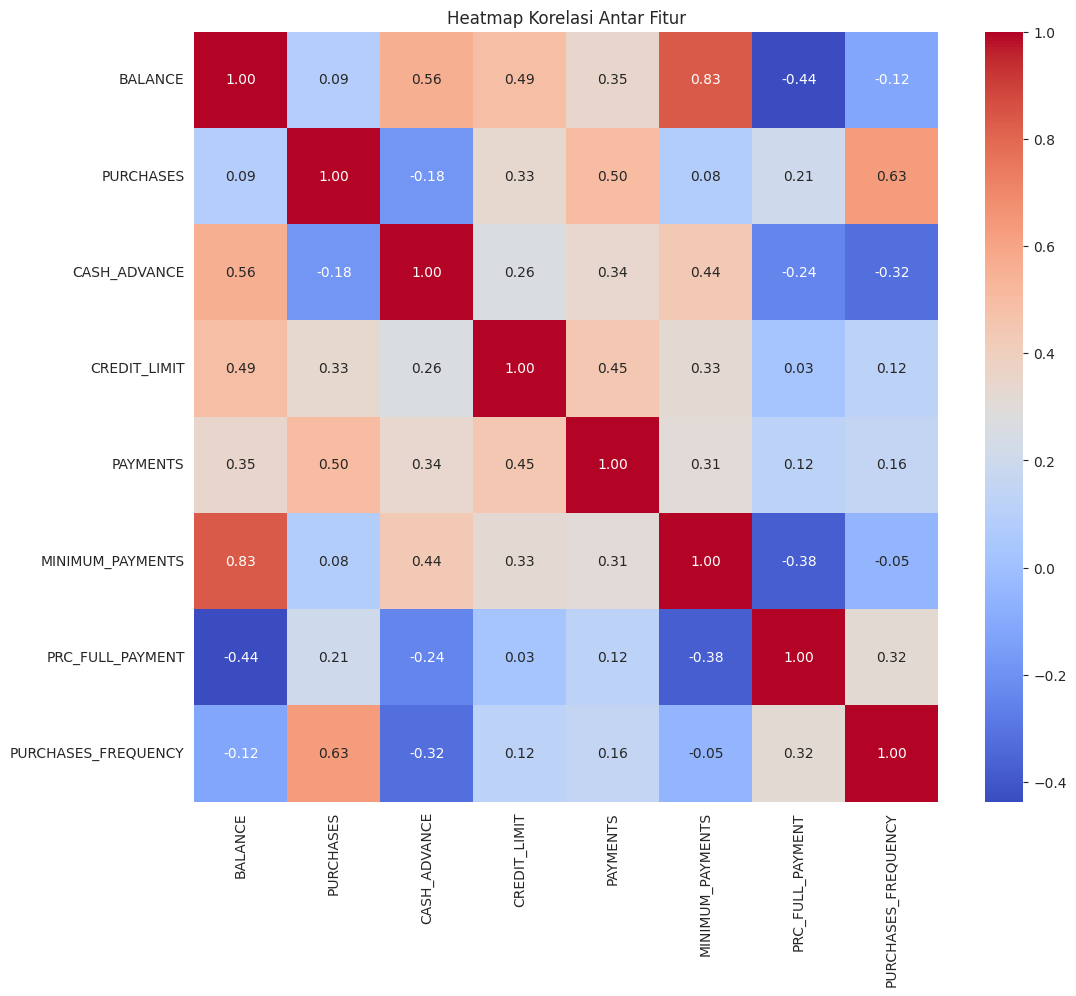

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# 1. Heatmap for feature correlation
plt.figure(figsize=(12, 10))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur')
plt.show()

def bivariat(x,y):
  plt.figure(figsize=(12, 6))
  sns.scatterplot(x=f'{x}', y=f'{y}', data=df_features)
  plt.xlabel(f'{x}')
  plt.ylabel(f'{y}')
  plt.title(f'{x} vs {y}')
  plt.show()

1. Plotting BALANCE vs PURCHASES



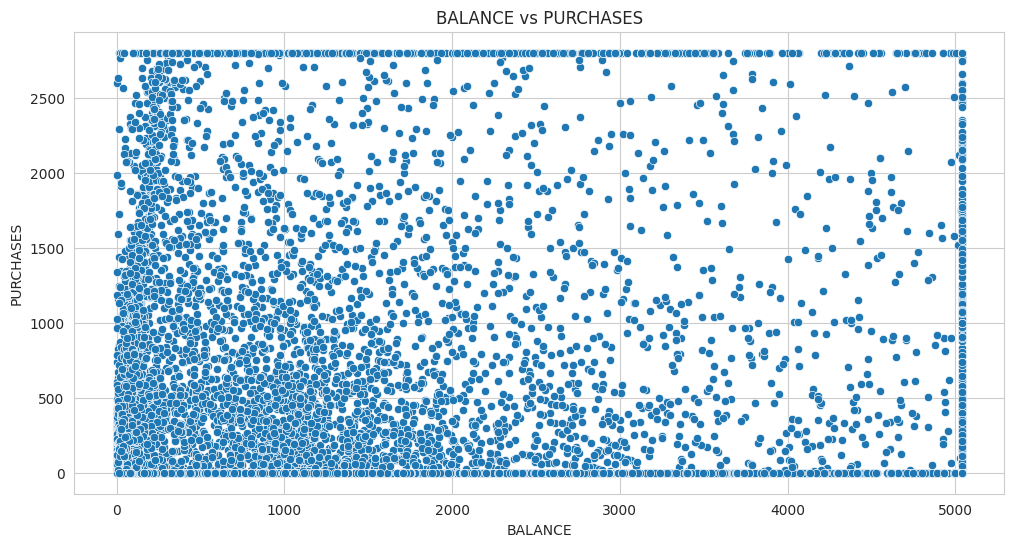



2. Plotting BALANCE vs CASH_ADVANCE



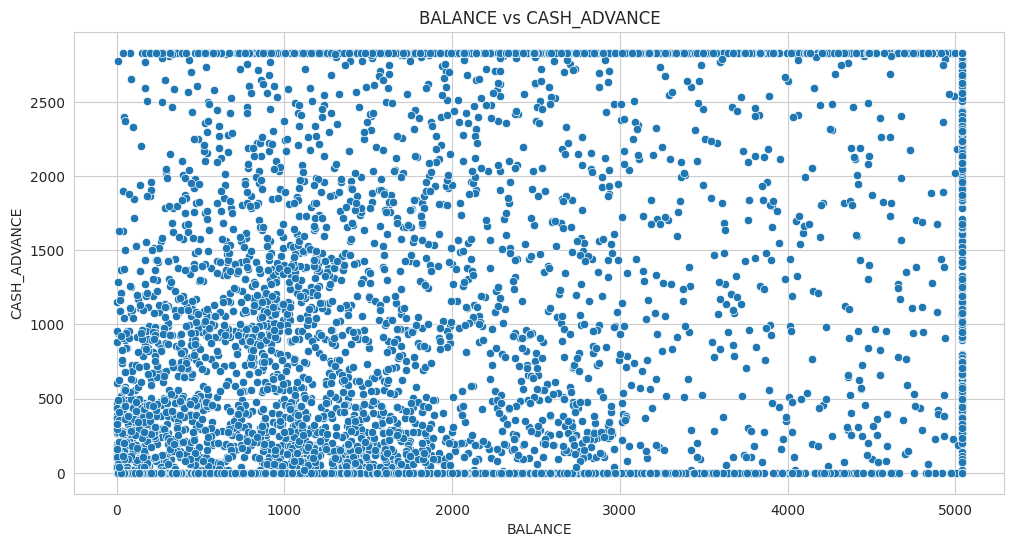



3. Plotting BALANCE vs CREDIT_LIMIT



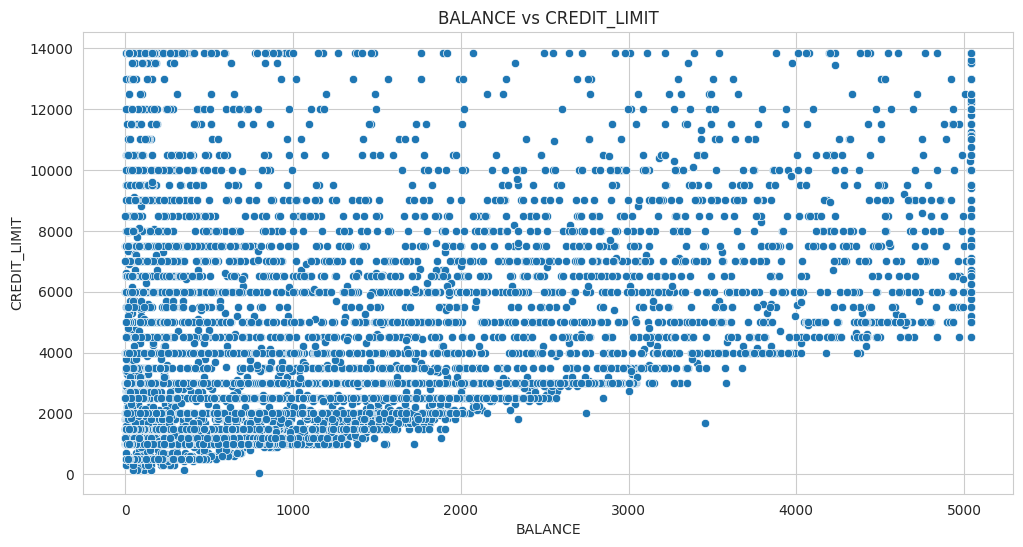



4. Plotting BALANCE vs PAYMENTS



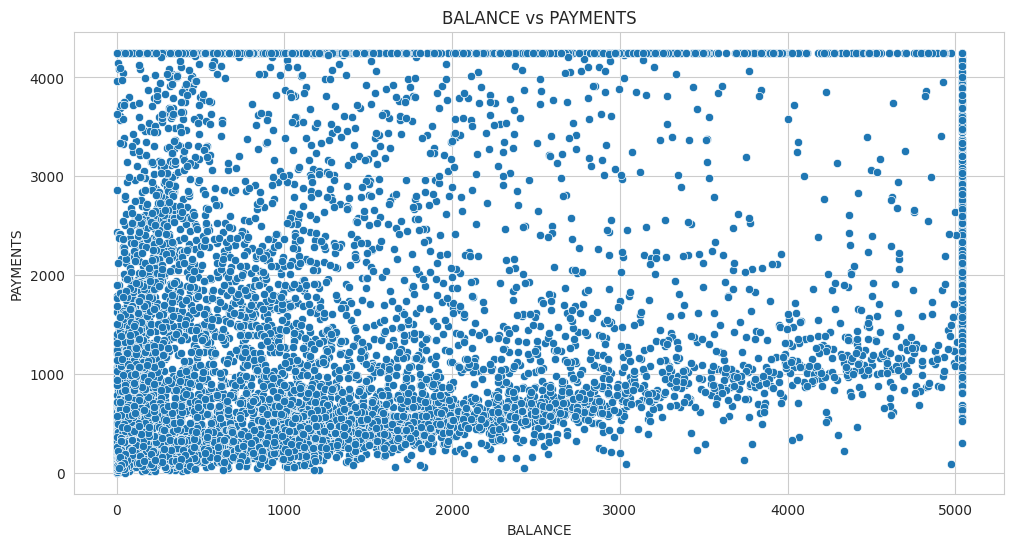



5. Plotting BALANCE vs MINIMUM_PAYMENTS



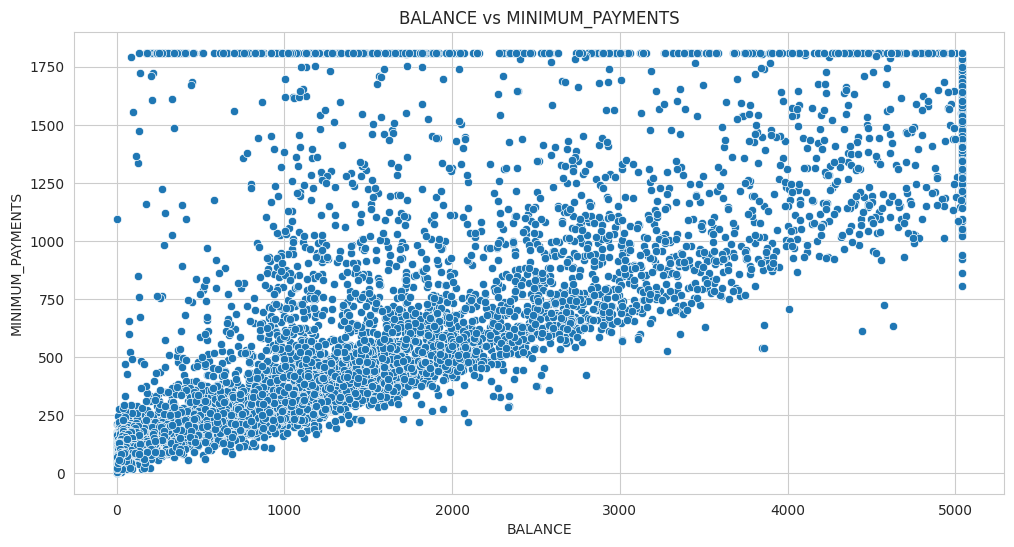



6. Plotting BALANCE vs PRC_FULL_PAYMENT



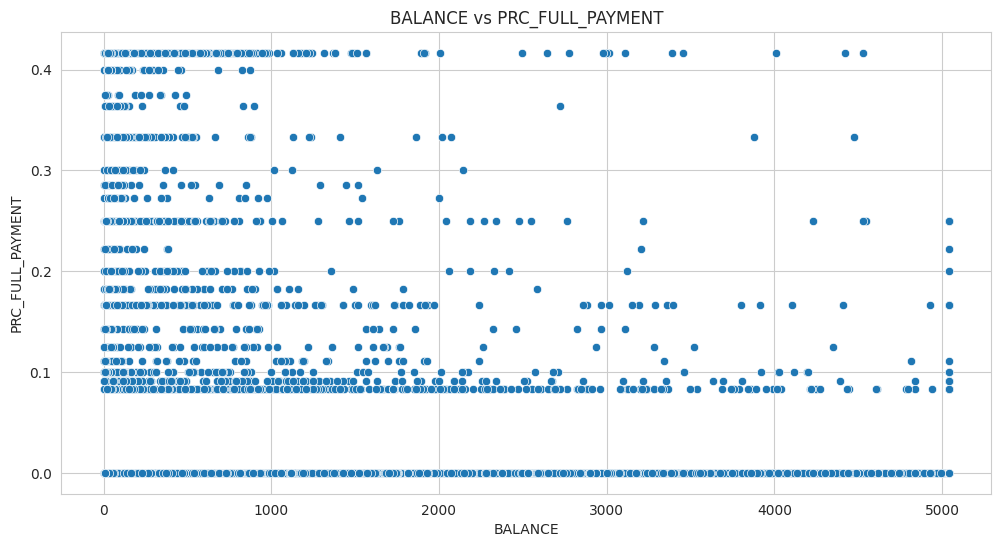



7. Plotting BALANCE vs PURCHASES_FREQUENCY



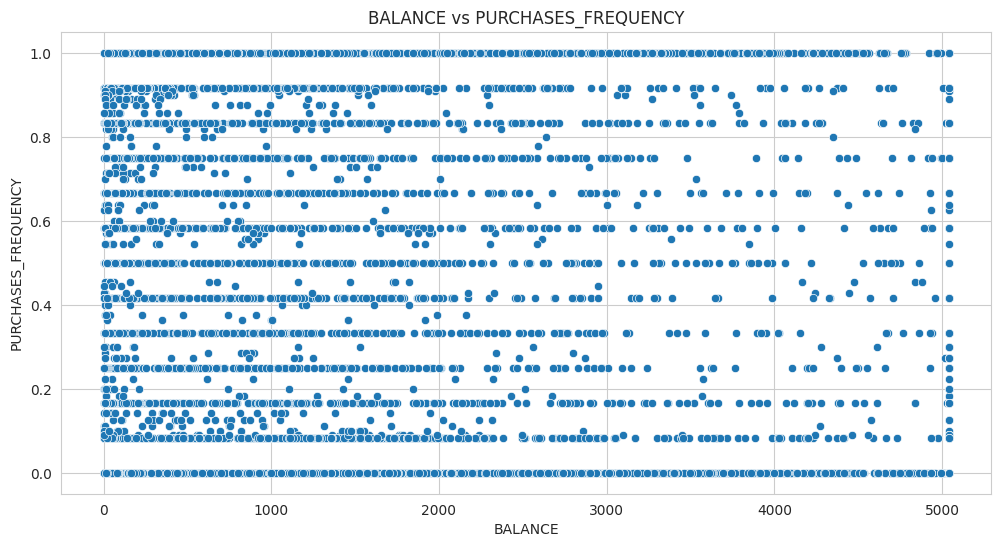



8. Plotting PURCHASES vs CASH_ADVANCE



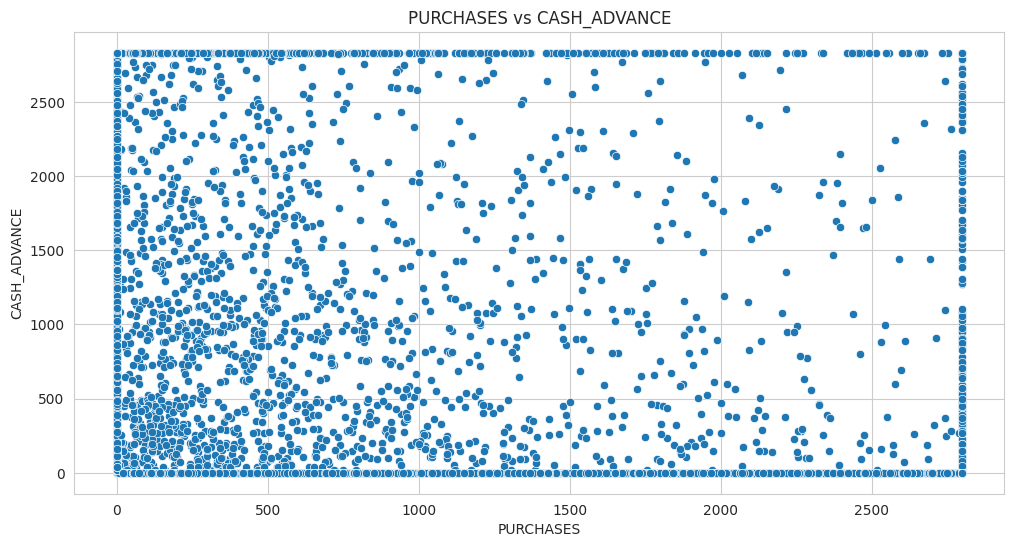



9. Plotting PURCHASES vs CREDIT_LIMIT



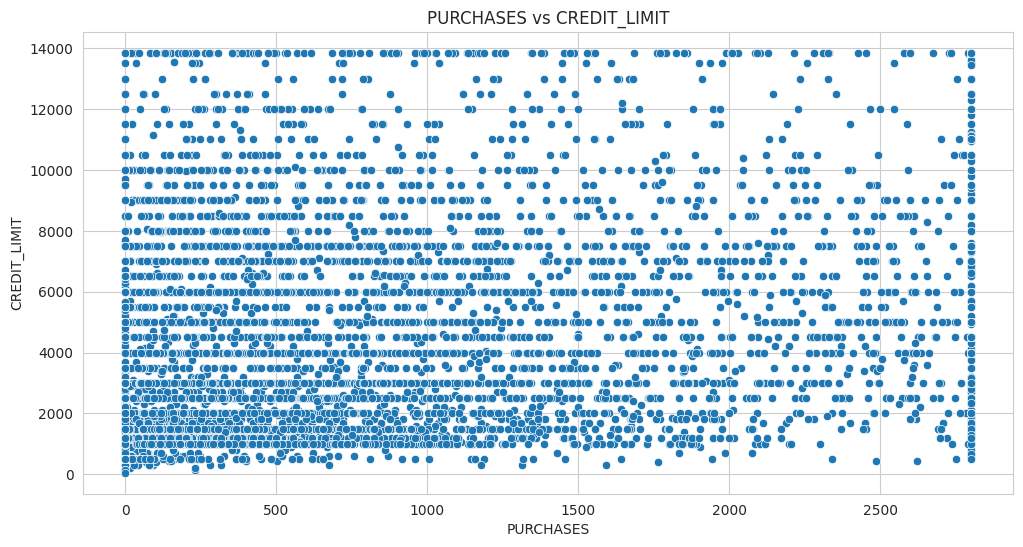



10. Plotting PURCHASES vs PAYMENTS



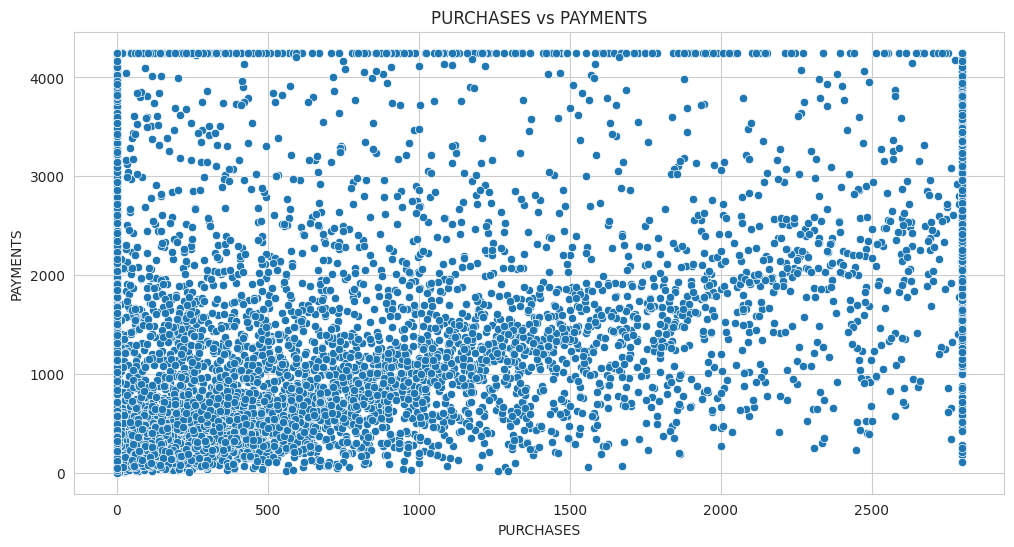



11. Plotting PURCHASES vs MINIMUM_PAYMENTS



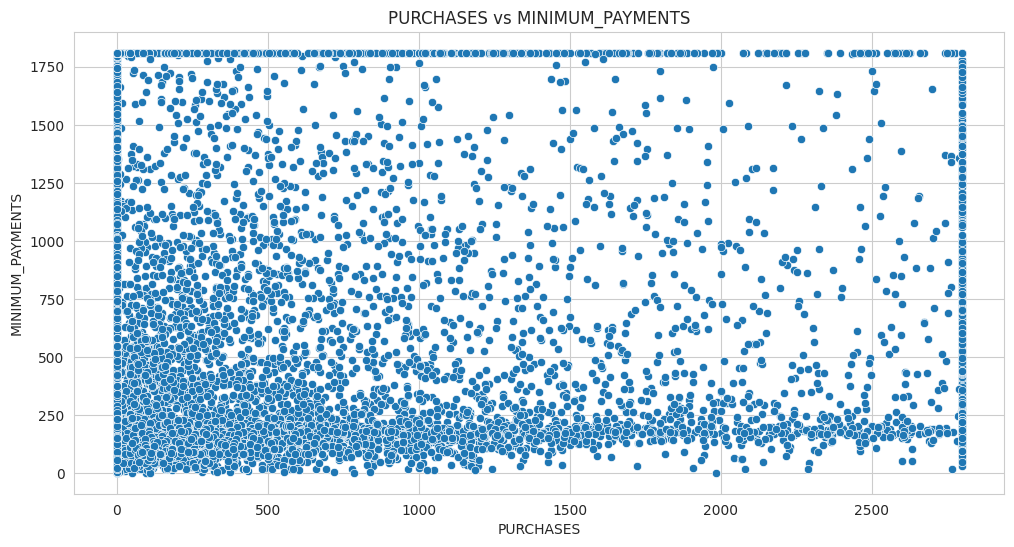



12. Plotting PURCHASES vs PRC_FULL_PAYMENT



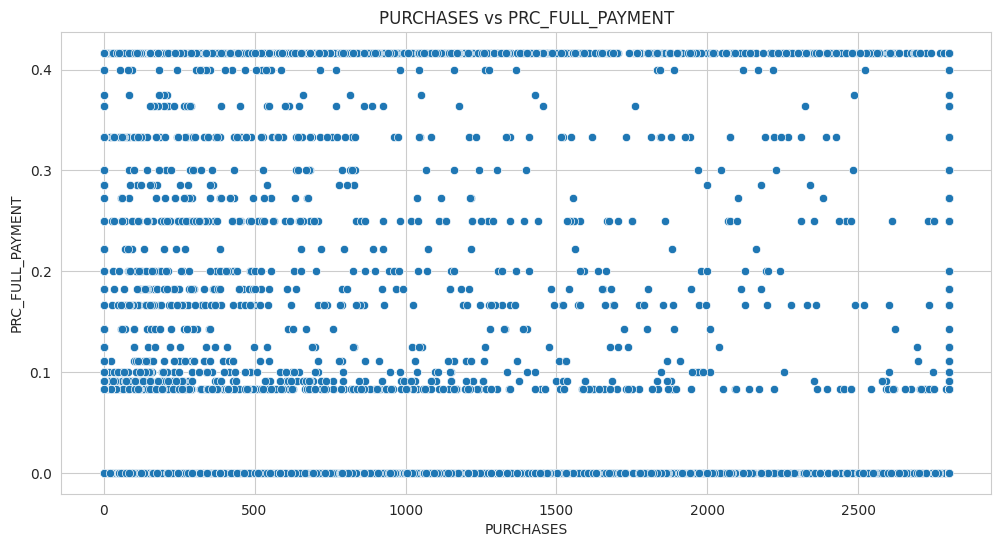



13. Plotting PURCHASES vs PURCHASES_FREQUENCY



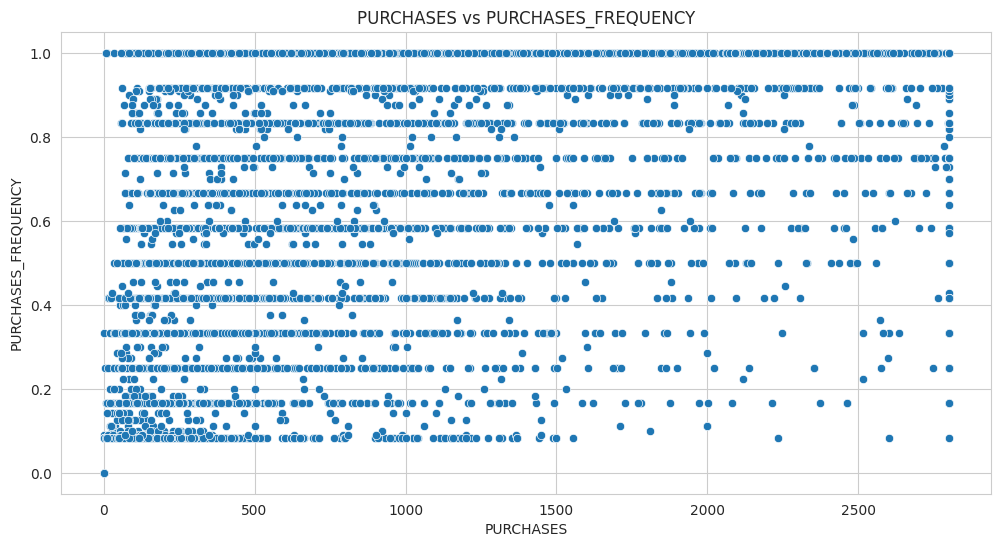



14. Plotting CASH_ADVANCE vs CREDIT_LIMIT



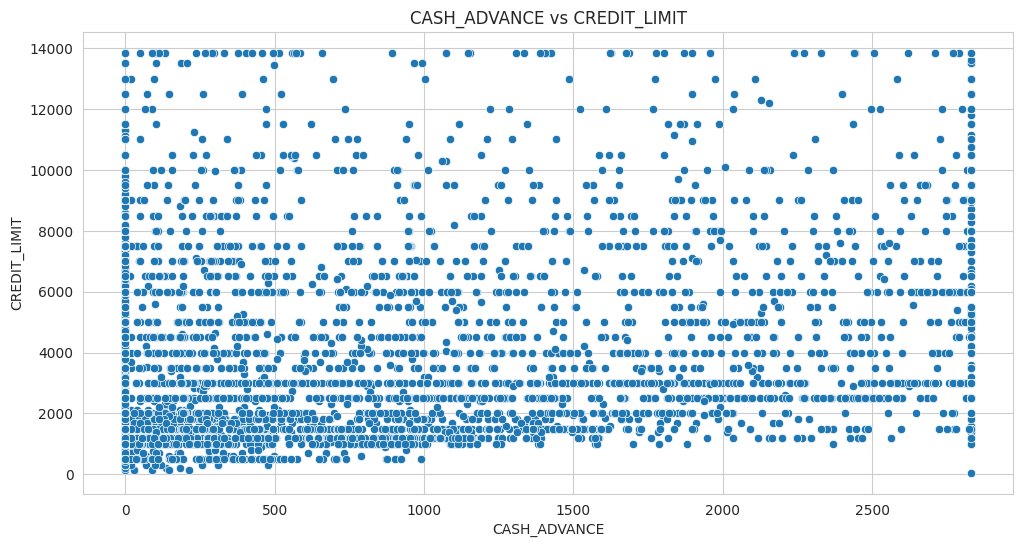



15. Plotting CASH_ADVANCE vs PAYMENTS



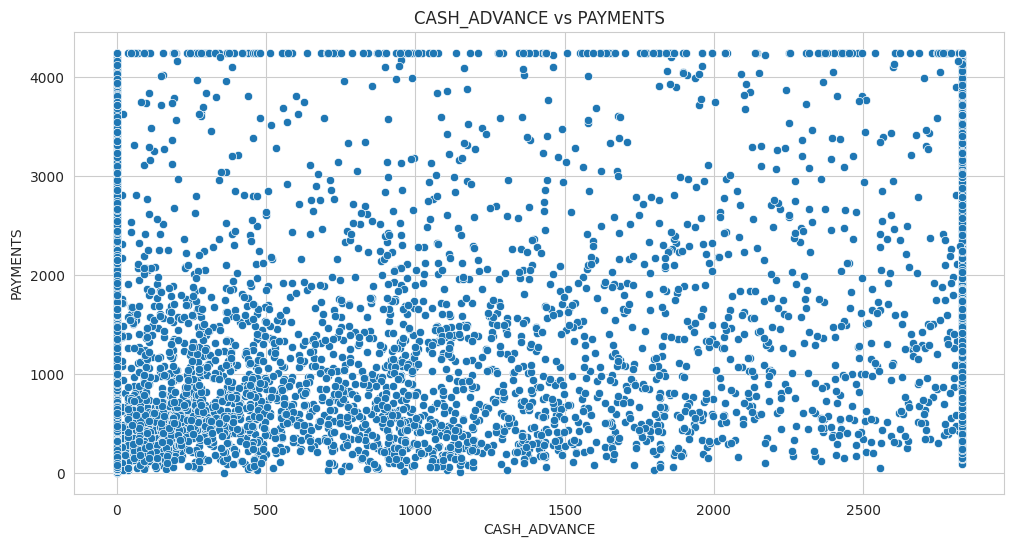



16. Plotting CASH_ADVANCE vs MINIMUM_PAYMENTS



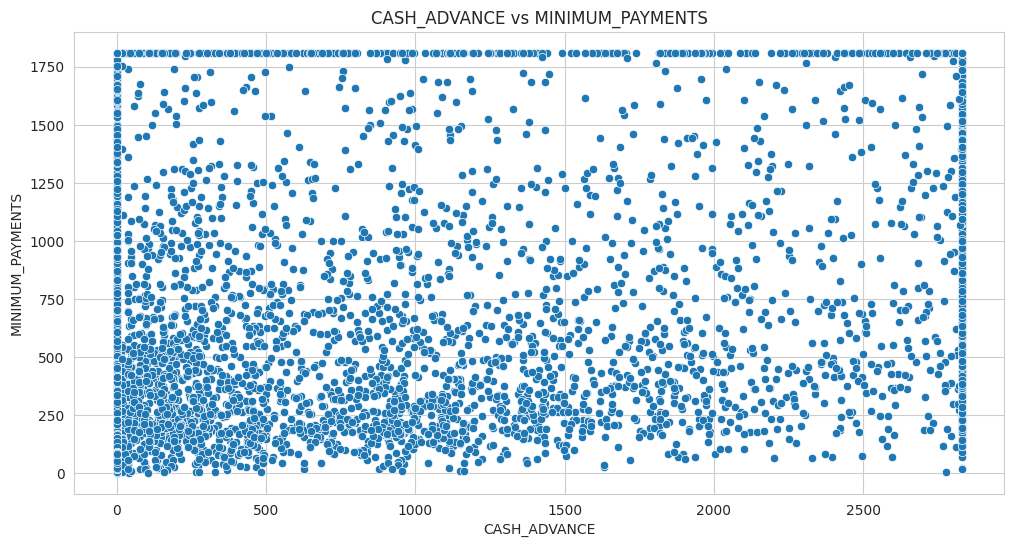



17. Plotting CASH_ADVANCE vs PRC_FULL_PAYMENT



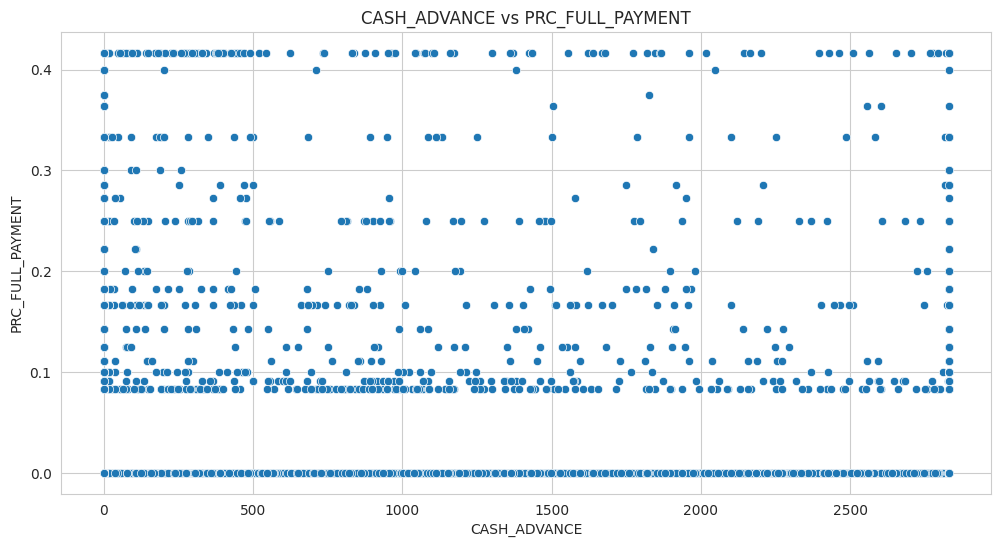



18. Plotting CASH_ADVANCE vs PURCHASES_FREQUENCY



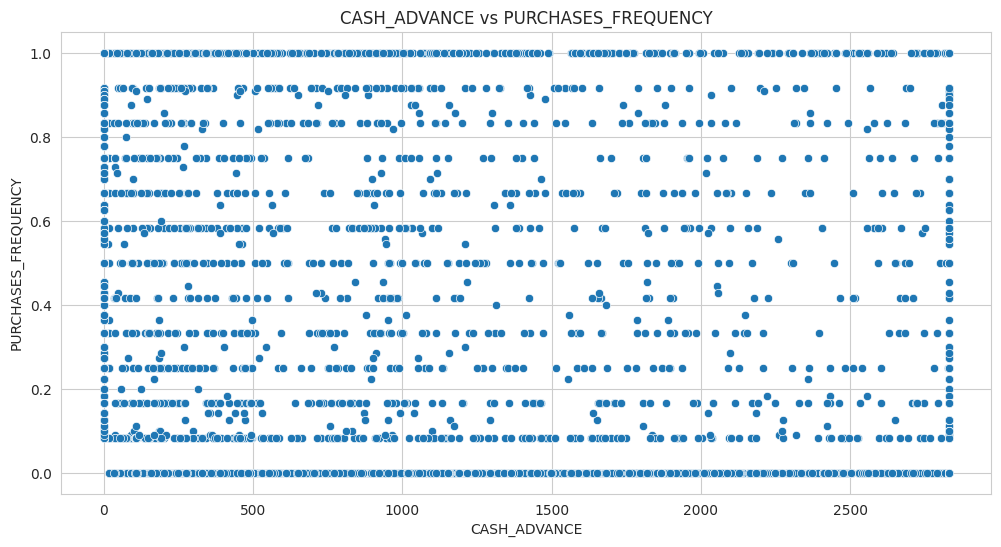



19. Plotting CREDIT_LIMIT vs PAYMENTS



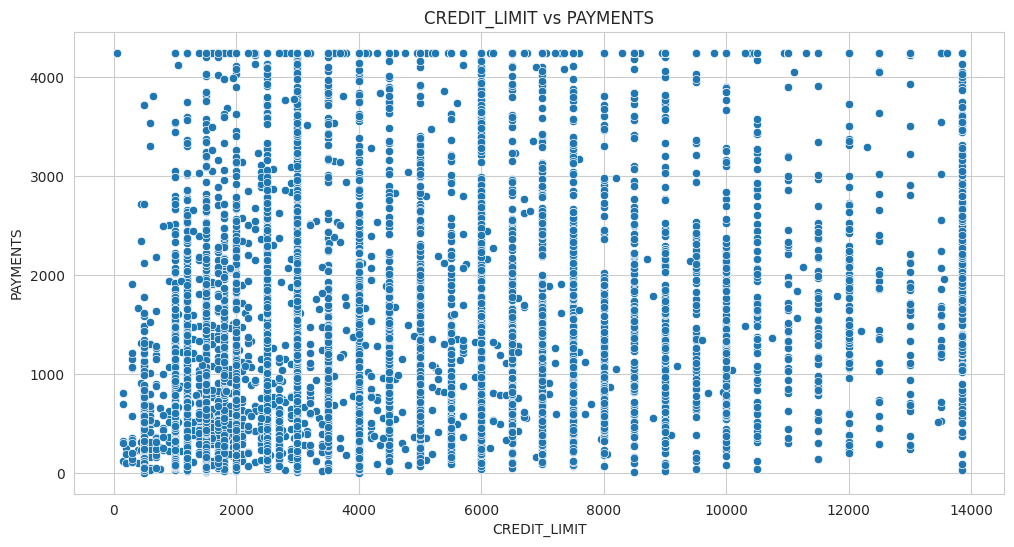



20. Plotting CREDIT_LIMIT vs MINIMUM_PAYMENTS



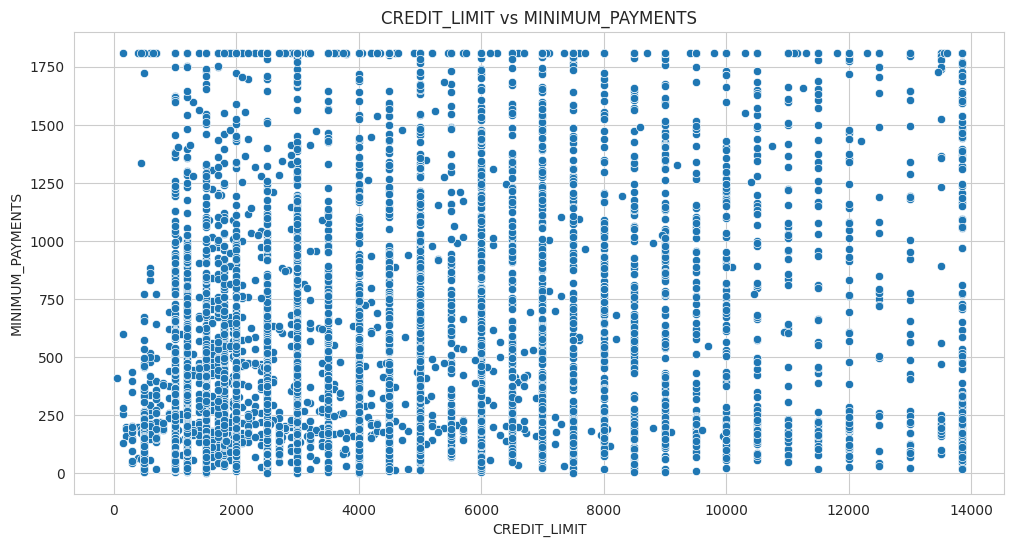



21. Plotting CREDIT_LIMIT vs PRC_FULL_PAYMENT



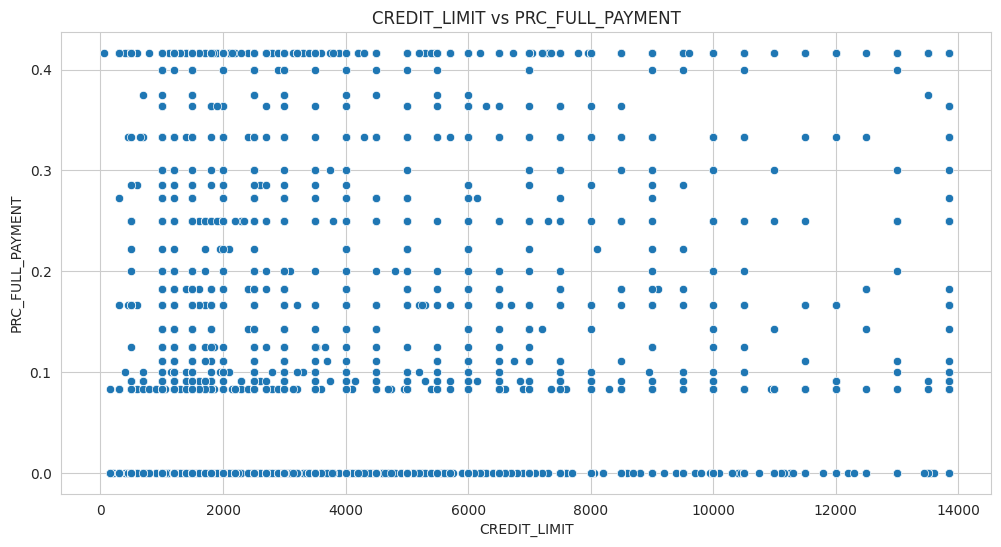



22. Plotting CREDIT_LIMIT vs PURCHASES_FREQUENCY



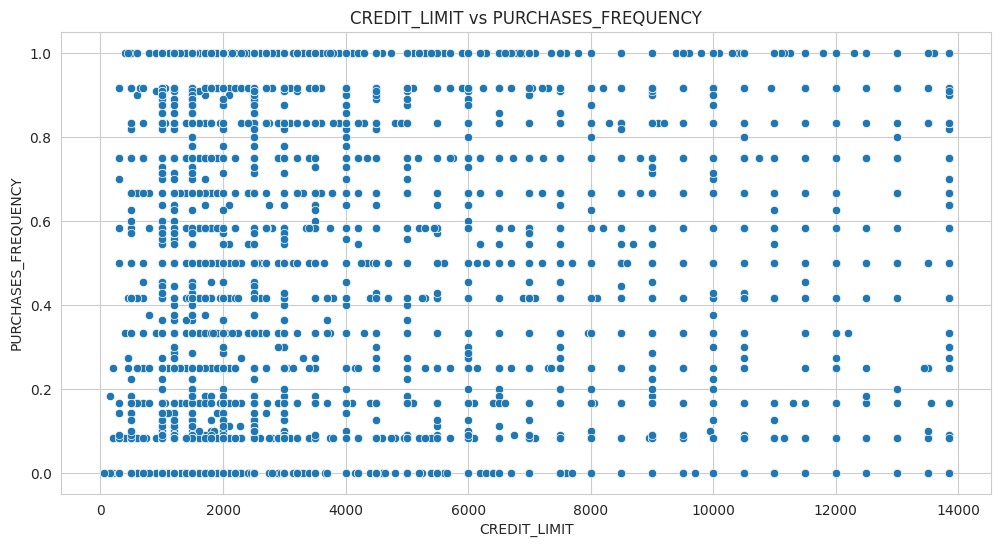



23. Plotting PAYMENTS vs MINIMUM_PAYMENTS



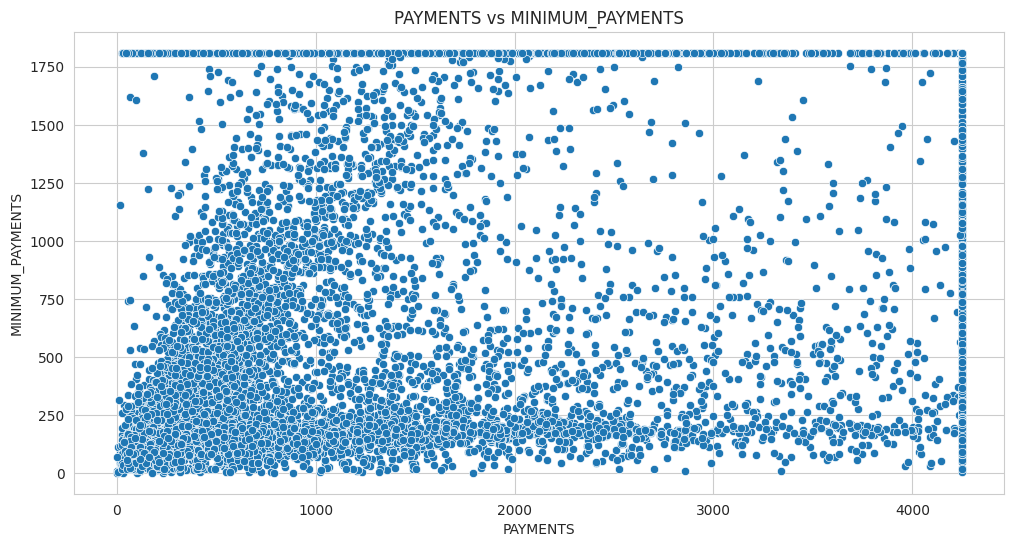



24. Plotting PAYMENTS vs PRC_FULL_PAYMENT



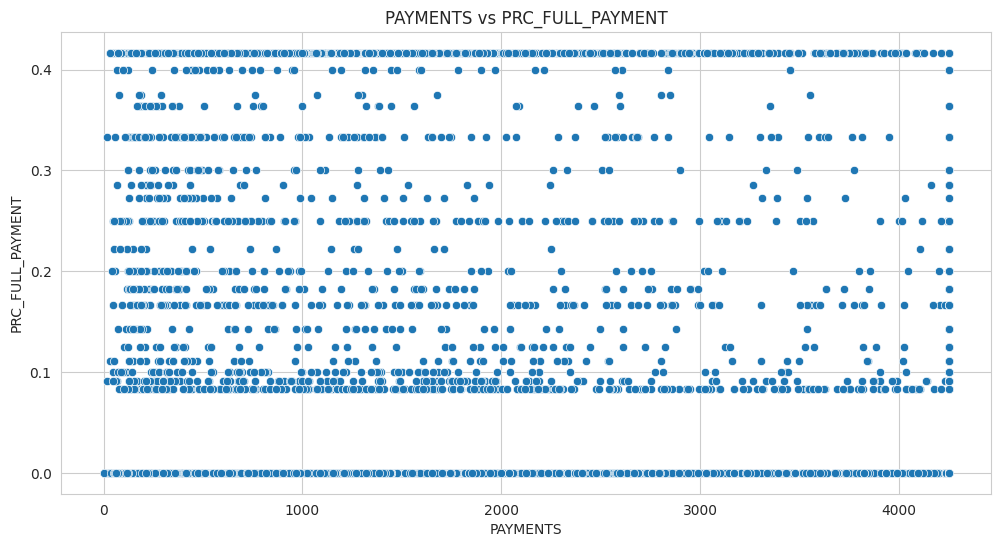



25. Plotting PAYMENTS vs PURCHASES_FREQUENCY



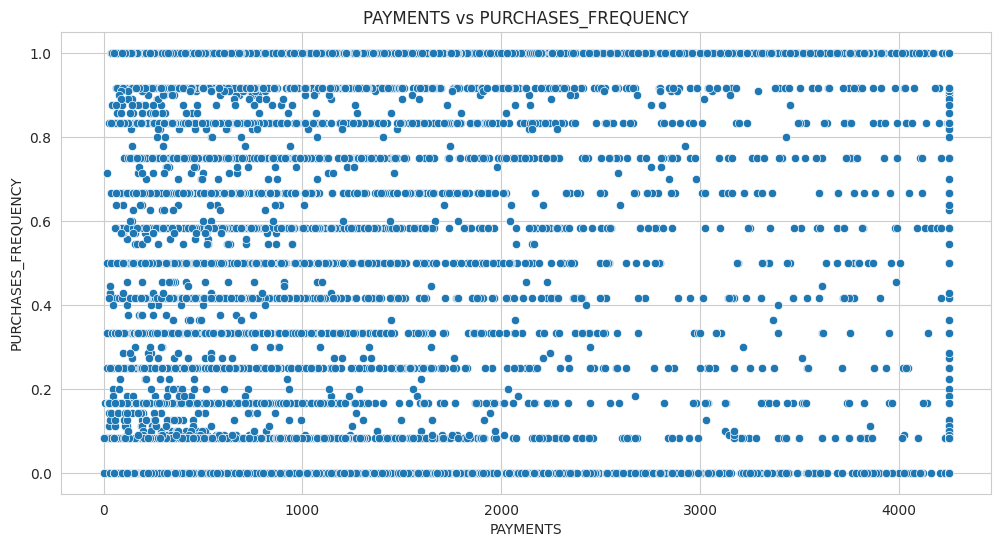



26. Plotting MINIMUM_PAYMENTS vs PRC_FULL_PAYMENT



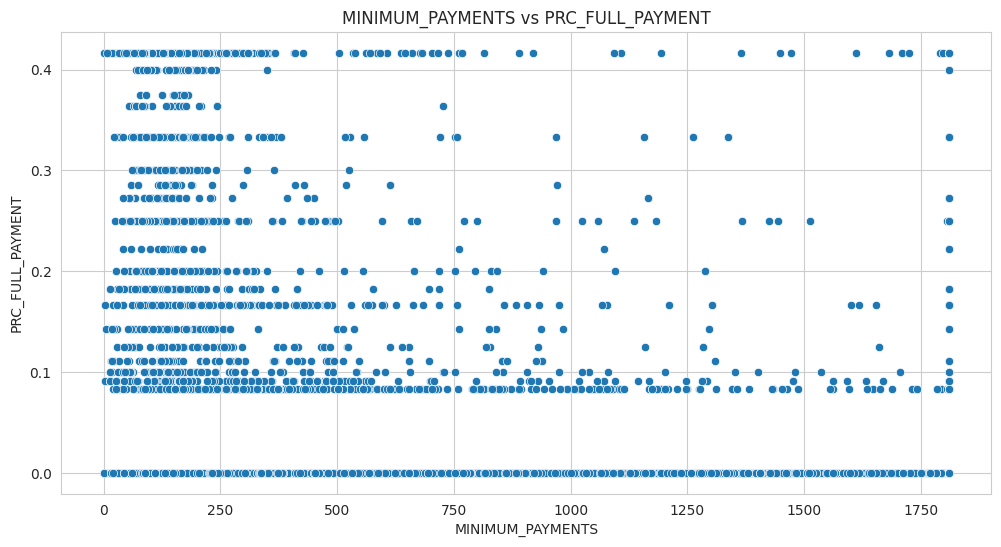



27. Plotting MINIMUM_PAYMENTS vs PURCHASES_FREQUENCY



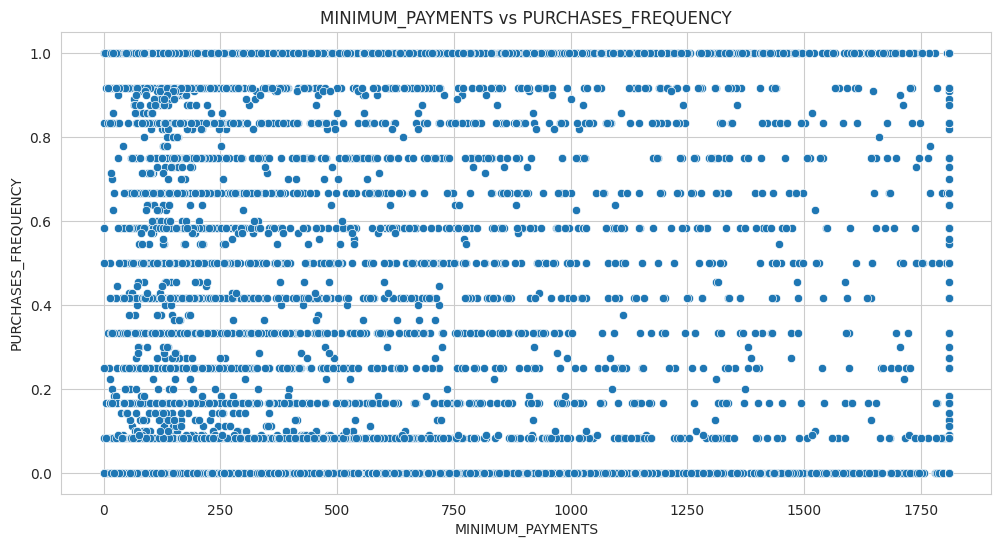



28. Plotting PRC_FULL_PAYMENT vs PURCHASES_FREQUENCY



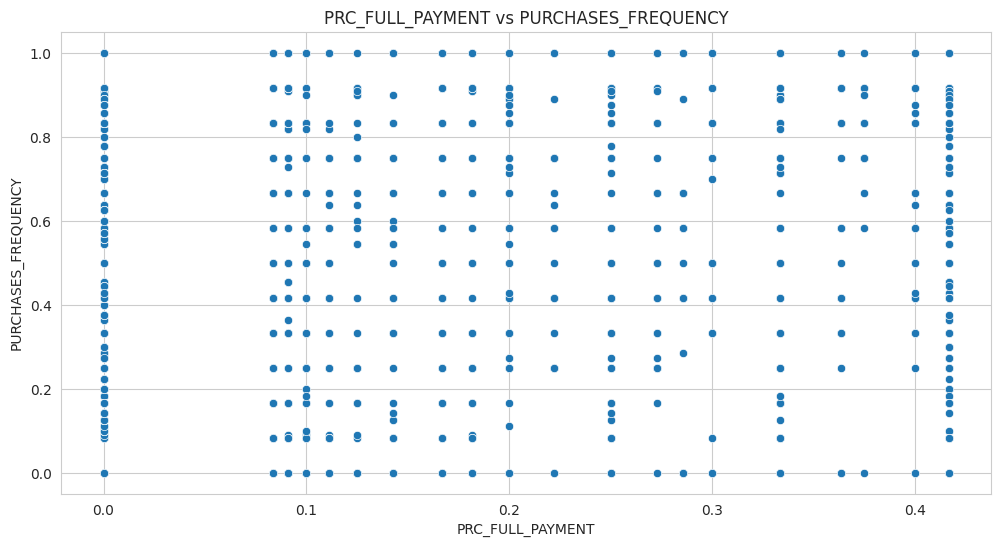

In [47]:
feature_list = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY']

# Iterate through all unique pairs of features for bivariate plotting
x = 1
for i in range(len(feature_list)):
  for j in range(i + 1, len(feature_list)): # Start j from i+1 to avoid plotting a feature against itself and duplicate pairs (e.g., A vs B and B vs A)
    print(f"{x}. Plotting {feature_list[i]} vs {feature_list[j]}\n")
    bivariat(feature_list[i], feature_list[j])
    print("\n ========================================= \n")
    x += 1

### **4. Penyetaraan Skala (Standard Scaling)**

**Analisis Krusial (Penting untuk Clustering):**
Tanpa scaling, fitur dengan nilai nominal besar (seperti `CREDIT_LIMIT`: ribuan/jutaan) akan mendominasi fitur bernilai kecil (seperti `FREQUENCY`: 0.0 - 1.0). Jarak Euclidean akan bias ke fitur nominal besar.

**Sisi Teknikal:**
> Kita menerapkan **StandardScaler (Z-Score Normalization)**.
> Transformasi: $z = (x - \mu) / \sigma$
> Hasilnya, semua fitur akan memiliki Mean = 0 dan Standar Deviasi = 1. Ini membuat algoritma berbasis jarak (K-Means/DBSCAN) bekerja secara adil pada setiap dimensi.

**Penjelasan Awam:**
> "Komputer itu bingung membandingkan 'Gaji' (Jutaan Rupiah) dengan 'Frekuensi Belanja' (1-10 kali). Angka jutaan pasti menang telak.
> Jadi, kita lakukan **Penyetaraan**. Semuanya kita ubah ke satuan standar 'Skor Z'. Jadi Gaji dan Frekuensi punya hak suara yang sama dalam menentukan kelompok."

In [48]:
from sklearn.preprocessing import StandardScaler

print("StandardScaler imported successfully.")

StandardScaler imported successfully.


Setelah install scaller, di implementasikan ke dataset

In [49]:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)
display(df_scaled.head())
print(f"Shape of df_scaled: {df_scaled.shape}")

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
0 -0.891045  -0.734417     -0.675965     -1.013101 -0.929780   
1  1.137098  -0.840081      2.116051      0.751136  2.107304   
2  0.683354   0.016273     -0.675965      0.898156 -0.602606   
3 -0.392720  -0.822359     -0.675965     -0.954293 -0.558802   
4  0.243721   0.636644     -0.675965     -0.777870  0.003055   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  
0         -0.777616         -0.629480            -0.820769  
1          0.887194          0.766378            -1.236139  
2          0.092910         -0.629480             1.256077  
3         -0.589721         -0.629480            -1.028455  
4          2.203678         -0.629480             0.425339

Shape of df_scaled: (8636, 8)


### **5. Pemodelan Cluster 1: K-Means (The Gold Standard)**

**Analisis Tahapan (Mencari K Optimal):**
Sebelum mengelompokkan, kita harus tahu dulu: *Berapa jumlah kelompok yang paling pas?* Kita tidak menebak, tapi menghitung.

**Sisi Teknikal:**
> Menggunakan **Elbow Method**. Kita memplot nilai **WCSS (Within-Cluster Sum of Squares)**—yaitu total jarak error kuadrat dari titik ke pusat cluster.
> * **Cara Baca:** Cari titik di mana penurunan WCSS mulai melambat drastis (membentuk siku). Di situlah *trade-off* terbaik antara kompleksitas model dan akurasi.

**Penjelasan Awam:**
> "Kita mau memotong kue bolu ini jadi berapa potong? 3? 5? atau 10?
> Grafik 'Siku' di bawah ini memberi petunjuk. Kita cari titik di mana garisnya mulai melandai. Itu adalah jumlah potongan paling efisien—tidak terlalu besar (terlalu umum), tapi juga tidak terlalu kecil (terlalu ribet)."

In [50]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

print("KMeans and matplotlib.pyplot imported successfully.")

KMeans and matplotlib.pyplot imported successfully.


8636
Banyaknya Kategori Clustering : 6


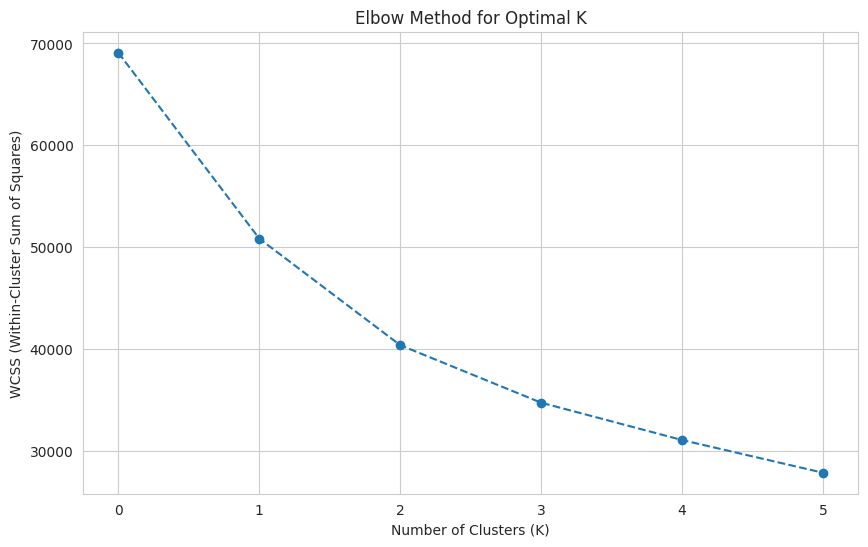

Elbow Method plot displayed. Look for the 'elbow point' to determine the optimal number of clusters.


In [51]:
wcss = []
total_entry = int(df_scaled.shape[0])
print(total_entry)
category_clust = int(input("Banyaknya Kategori Clustering : "))
for i in range(1, category_clust+1): # Loop from 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(0, category_clust), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(0, category_clust))
plt.grid(True)
plt.show()

print("Elbow Method plot displayed. Look for the 'elbow point' to determine the optimal number of clusters.")

Berdasarkan plot 'Elbow Method' di atas, kita perlu mencari titik 'siku' (elbow point) di mana penurunan nilai WCSS (Within-Cluster Sum of Squares) mulai melambat secara signifikan. Dari plot yang ditampilkan, titik 'siku' tampak berada di sekitar K = 3 atau K = 4. Ini berarti 3 atau 4 adalah jumlah kluster yang optimal untuk data ini, karena menambahkan lebih banyak kluster setelah titik ini tidak akan memberikan banyak informasi tambahan atau mengurangi variansi secara substansial.

Dalam konteks analisis ini, **K=3 atau K=4** dapat dianggap sebagai jumlah kluster yang optimal. Untuk langkah selanjutnya, kita bisa memilih salah satu dari nilai ini.

In [52]:
kmeans_model = KMeans(n_clusters=category_clust, init='k-means++', random_state=42, n_init=10)
df_scaled['Cluster'] = kmeans_model.fit_predict(df_scaled)
display(df_scaled.head())
print(f"Shape of df_scaled after adding cluster labels: {df_scaled.shape}")

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
0 -0.891045  -0.734417     -0.675965     -1.013101 -0.929780   
1  1.137098  -0.840081      2.116051      0.751136  2.107304   
2  0.683354   0.016273     -0.675965      0.898156 -0.602606   
3 -0.392720  -0.822359     -0.675965     -0.954293 -0.558802   
4  0.243721   0.636644     -0.675965     -0.777870  0.003055   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  Cluster  
0         -0.777616         -0.629480            -0.820769        4  
1          0.887194          0.766378            -1.236139        3  
2          0.092910         -0.629480             1.256077        1  
3         -0.589721         -0.629480            -1.028455        4  
4          2.203678         -0.629480             0.425339        1

Shape of df_scaled after adding cluster labels: (8636, 9)


In [53]:
cluster_counts = df_scaled['Cluster'].value_counts()
print("Number of data points per cluster:")
display(cluster_counts)

Number of data points per cluster:


Cluster
4    2612
1    1819
2    1346
3    1307
0     827
5     725
Name: count, dtype: int64

### **6. Pemodelan Cluster 2: DBSCAN (Deteksi Kepadatan & Noise)**

**Analisis Krusial (Tentang Parameter Ajaib):**
DBSCAN sangat berbeda dengan K-Means. Dia tidak butuh input jumlah cluster ($k$), tapi butuh definisi "kepadatan".

**Sisi Teknikal:**
> * **Parameter `eps` (0.5 - 1.0):** Radius lingkaran pencarian tetangga.
> * **Parameter `min_samples`:** Jumlah tetangga minimal agar disebut "Cluster".
> * **Output `-1` (Noise):** Keunggulan utama DBSCAN. Data yang terlalu jauh/sepi tidak akan dipaksa masuk cluster, melainkan dilabeli `-1`. Ini sangat berguna untuk *Fraud Detection*.

**Penjelasan Awam:**
> "Kalau K-Means membagi wilayah seperti memotong kue, DBSCAN itu seperti **mencari kerumunan orang di pesta**.
> * Dia akan mengelompokkan orang-orang yang ngumpul rapat.
> * Orang yang menyendiri di pojokan (tidak punya teman ngobrol) akan diberi label **'-1' (Orang Asing/Unik)**.
> * Orang label -1 ini menarik: bisa jadi mereka nasabah bermasalah, atau justru nasabah super unik."

In [54]:
from sklearn.cluster import DBSCAN

samples_fit = int(input(f"Minimal Sample DBSCAN (0 - {int(df_scaled.shape[0]/(category_clust*2))}) : "))

dbscan_model = DBSCAN(eps=1, min_samples=samples_fit, metric='euclidean')
df_scaled['DBSCAN_Cluster'] = dbscan_model.fit_predict(df_scaled.drop('Cluster', axis=1))

display(df_scaled.head())
print(f"Shape of df_scaled after adding DBSCAN cluster labels: {df_scaled.shape}")

Minimal Sample DBSCAN (0 - 719) : 350


BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
0 -0.891045  -0.734417     -0.675965     -1.013101 -0.929780   
1  1.137098  -0.840081      2.116051      0.751136  2.107304   
2  0.683354   0.016273     -0.675965      0.898156 -0.602606   
3 -0.392720  -0.822359     -0.675965     -0.954293 -0.558802   
4  0.243721   0.636644     -0.675965     -0.777870  0.003055   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  Cluster  \
0         -0.777616         -0.629480            -0.820769        4   
1          0.887194          0.766378            -1.236139        3   
2          0.092910         -0.629480             1.256077        1   
3         -0.589721         -0.629480            -1.028455        4   
4          2.203678         -0.629480             0.425339        1   

   DBSCAN_Cluster  
0               0  
1              -1  
2              -1  
3               0  
4              -1

Shape of df_scaled after adding DBSCAN cluster labels: (8636, 10)


In [55]:
dbscan_cluster_counts = df_scaled['DBSCAN_Cluster'].value_counts()
print("Number of data points per DBSCAN cluster:")
display(dbscan_cluster_counts)

Number of data points per DBSCAN cluster:


DBSCAN_Cluster
-1    4987
 0    2836
 1     813
Name: count, dtype: int64

### **7. Pemodelan Cluster 3: Hierarchical (Struktur Silsilah)**

**Analisis Tahapan (Membaca Dendrogram):**
Metode ini membangun peta kekerabatan data dari bawah ke atas (*Agglomerative*).

**Sisi Teknikal:**
> Kita menggunakan **Linkage Ward** (meminimalkan varians). Visualisasi **Dendrogram** menunjukkan bagaimana cluster-cluster kecil bergabung.
> * **Cara Menentukan Cluster:** Kita memotong garis vertikal terpanjang yang tidak memotong garis horizontal (batas penggabungan). Garis potong itulah yang menentukan jumlah cluster natural data ini.

**Penjelasan Awam:**
> "Ini adalah **Pohon Silsilah Keluarga** pelanggan.
> Kita bisa melihat siapa mirip dengan siapa. Semakin pendek garis hubungnya, semakin mirip perilaku mereka. Kita memotong 'dahan' pohon ini untuk menentukan batas keluarga besar mana saja yang terbentuk."

In [56]:
from sklearn.cluster import AgglomerativeClustering

# Buat DataFrame baru tanpa label cluster yang sudah ada
# Pastikan df_scaled sudah didefinisikan sebelumnya
df_hierarchical_features = df_scaled.drop(columns=['Cluster', 'DBSCAN_Cluster'], errors='ignore') # tambah errors='ignore' jaga-jaga kalau kolomnya tidak ada

# Instantiate AgglomerativeClustering model
# GANTI 'affinity' MENJADI 'metric'
agg_clustering = AgglomerativeClustering(n_clusters=category_clust, metric='euclidean', linkage='ward')

# Fit model dan prediksi
df_scaled['Hierarchical_Cluster'] = agg_clustering.fit_predict(df_hierarchical_features)

# Tampilkan hasil
display(df_scaled.head())
print(f"Shape of df_scaled after adding Hierarchical Cluster labels: {df_scaled.shape}")

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
0 -0.891045  -0.734417     -0.675965     -1.013101 -0.929780   
1  1.137098  -0.840081      2.116051      0.751136  2.107304   
2  0.683354   0.016273     -0.675965      0.898156 -0.602606   
3 -0.392720  -0.822359     -0.675965     -0.954293 -0.558802   
4  0.243721   0.636644     -0.675965     -0.777870  0.003055   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  Cluster  \
0         -0.777616         -0.629480            -0.820769        4   
1          0.887194          0.766378            -1.236139        3   
2          0.092910         -0.629480             1.256077        1   
3         -0.589721         -0.629480            -1.028455        4   
4          2.203678         -0.629480             0.425339        1   

   DBSCAN_Cluster  Hierarchical_Cluster  
0               0                     1  
1              -1                     3  
2              -1                     5  
3               0                     1  
4              -1                     5

Shape of df_scaled after adding Hierarchical Cluster labels: (8636, 11)


In [57]:
from sklearn.cluster import AgglomerativeClustering

# Create a new DataFrame without existing cluster labels for hierarchical clustering
df_hierarchical_features = df_scaled.drop(columns=['Cluster', 'DBSCAN_Cluster'])

# Instantiate AgglomerativeClustering model
# Using n_clusters=3 as an initial value, can be adjusted
# metric='euclidean' and linkage='ward' are common choices
agg_clustering = AgglomerativeClustering(n_clusters=category_clust, metric='euclidean', linkage='ward')

# Fit the model and predict cluster labels
df_scaled['Hierarchical_Cluster'] = agg_clustering.fit_predict(df_hierarchical_features)

# Display the head of the updated DataFrame and its shape
display(df_scaled.head())
print(f"Shape of df_scaled after adding Hierarchical Cluster labels: {df_scaled.shape}")

BALANCE  PURCHASES  CASH_ADVANCE  CREDIT_LIMIT  PAYMENTS  \
0 -0.891045  -0.734417     -0.675965     -1.013101 -0.929780   
1  1.137098  -0.840081      2.116051      0.751136  2.107304   
2  0.683354   0.016273     -0.675965      0.898156 -0.602606   
3 -0.392720  -0.822359     -0.675965     -0.954293 -0.558802   
4  0.243721   0.636644     -0.675965     -0.777870  0.003055   

   MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  PURCHASES_FREQUENCY  Cluster  \
0         -0.777616         -0.629480            -0.820769        4   
1          0.887194          0.766378            -1.236139        3   
2          0.092910         -0.629480             1.256077        1   
3         -0.589721         -0.629480            -1.028455        4   
4          2.203678         -0.629480             0.425339        1   

   DBSCAN_Cluster  Hierarchical_Cluster  
0               0                     2  
1              -1                     3  
2              -1                     5  
3               0                     2  
4              -1                     5

Shape of df_scaled after adding Hierarchical Cluster labels: (8636, 11)


In [58]:
hierarchical_cluster_counts = df_scaled['Hierarchical_Cluster'].value_counts()
print("Number of data points per Hierarchical Cluster:")
display(hierarchical_cluster_counts)

Number of data points per Hierarchical Cluster:


Hierarchical_Cluster
2    3088
3    1249
4    1167
1    1125
5    1059
0     948
Name: count, dtype: int64

### **7.1. Pemodelan Cluster 3: Hierarchical (Analisis Dendrogram)**

**Analisis Tahapan (Membaca Peta Silsilah):**
Dendrogram adalah diagram pohon yang menunjukkan bagaimana algoritma menggabungkan data satu per satu dari bawah ke atas (*Agglomerative*).

**Sisi Teknikal (Cara Menentukan K):**
> Sumbu Y merepresentasikan **Jarak Euclidean (Dissimilarity)**. Semakin tinggi garis vertikal, semakin "berbeda" kedua cluster yang digabungkan.
> * **Rule of Thumb:** Untuk menentukan jumlah cluster optimal ($k$), cari garis vertikal terpanjang yang **tidak dipotong** oleh garis horizontal (cabang) lainnya.
> * Kita menarik garis potong (*threshold*) pada ketinggian tersebut. Jumlah garis vertikal yang terpotong oleh threshold adalah jumlah cluster optimalnya.

**Penjelasan Awam (Analogi Silsilah Keluarga):**
> "Bayangkan ini adalah **Pohon Silsilah Keluarga** seluruh pelanggan kita.
> * **Di Bagian Bawah:** Setiap pelanggan berdiri sendiri-sendiri.
> * **Naik ke Atas:** Pelanggan yang mirip mulai bergandengan tangan membentuk 'keluarga kecil'.
> * **Makin ke Atas:** Keluarga-keluarga kecil bergabung menjadi 'Marga' atau klan besar.
>
> **Tugas Kita:** Memutuskan di level mana kita mau memotong silsilah ini? Apakah kita mau melihat sampai detail sepupu jauh (banyak kelompok kecil), atau cukup melihat garis keturunan utama saja (sedikit kelompok besar)? Garis vertikal yang paling panjang menunjukkan perbedaan yang paling mencolok antar kelompok."

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

print("dendrogram, linkage, and matplotlib.pyplot imported successfully.")

dendrogram, linkage, and matplotlib.pyplot imported successfully.


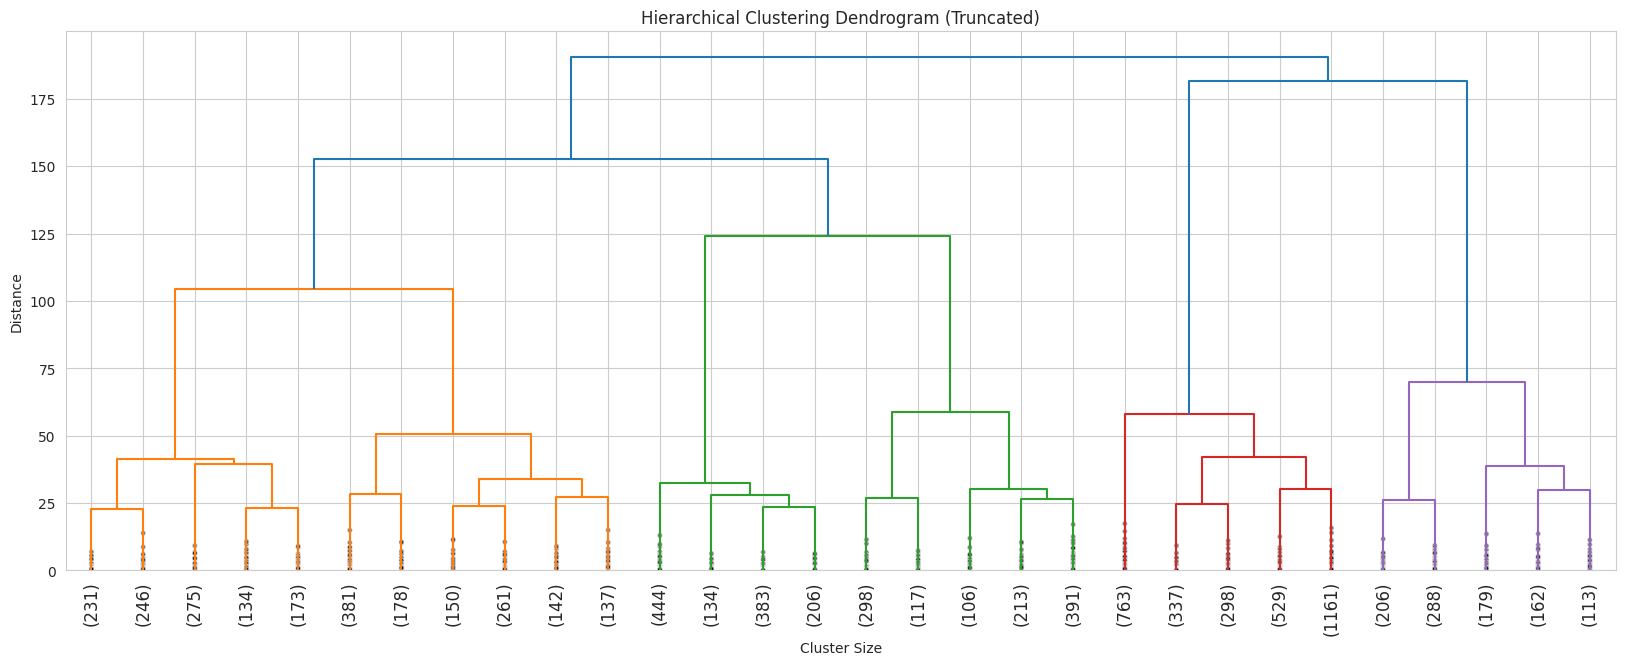

Dendrogram generated and displayed successfully.


In [60]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute the linkage matrix
linked_matrix = linkage(df_hierarchical_features, method='ward')

# Create a figure and axes for the dendrogram
plt.figure(figsize=(20, 7))
dendrogram(
    linked_matrix,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last 30 merged clusters
    show_leaf_counts=True,  # show the number of points in the leaf node
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a cleaner plot
)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()

print("Dendrogram generated and displayed successfully.")

### **8. Profiling & Interpretasi Bisnis (The "Face" of Clusters)**

**Analisis Krusial (Cara Membaca Grafik):**
Ini adalah tahap paling penting untuk *Business Intelligence*. Kita menerjemahkan angka matematika menjadi strategi manusia.

**Sisi Teknikal:**
> ***PENTING:*** Sumbu pada Radar Chart menggunakan skala **0.0 sampai 1.0 (Min-Max Scaled)**, bukan nilai Rupiah asli.
> * Nilai 1.0 = Cluster ini memiliki nilai rata-rata TERTINGGI di fitur tersebut dibanding cluster lain.
> * Nilai 0.0 = Cluster ini memiliki nilai TERENDAH.

**Penjelasan Awam & Contoh Baca:**
> "Grafik jaring laba-laba ini menunjukkan 'Kepribadian' setiap kelompok.
> 1. **Si Peminjam (The Borrower):** Jaringnya lancip ke arah **'Cash Advance'**. Mereka jarang belanja, tapi sering tarik tunai. *Risiko tinggi!*
> 2. **Si Sultan (The Spender):** Jaringnya lebar ke arah **'Purchases'** dan **'Credit Limit'**. Kartu kreditnya limit besar dan sering dipakai belanja. *Nasabah Emas!*
> 3. **Si Pasif (The Saver):** Jaringnya kecil di tengah. Jarang pakai kartu. *Perlu dipancing promo!*"

=== TABEL 1: DISTRIBUSI JUMLAH ANGGOTA CLUSTER ===


Metode         DBSCAN  Hierarchical  K-Means
Cluster_Label                               
-1               4987             0        0
 0               2836           948      827
 1                813          1125     1819
 2                  0          3088     1346
 3                  0          1249     1307
 4                  0          1167     2612
 5                  0          1059      725

/tmp/ipython-input-3148154264.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
/tmp/ipython-input-3148154264.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dbscan_cluster_counts.index, y=dbscan_cluster_counts.values, palette='magma')
/tmp/ipython-input-3148154264.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hierarchical_cluster_counts.index, y=hierarchical_cluster_counts.values, palette='plasma')


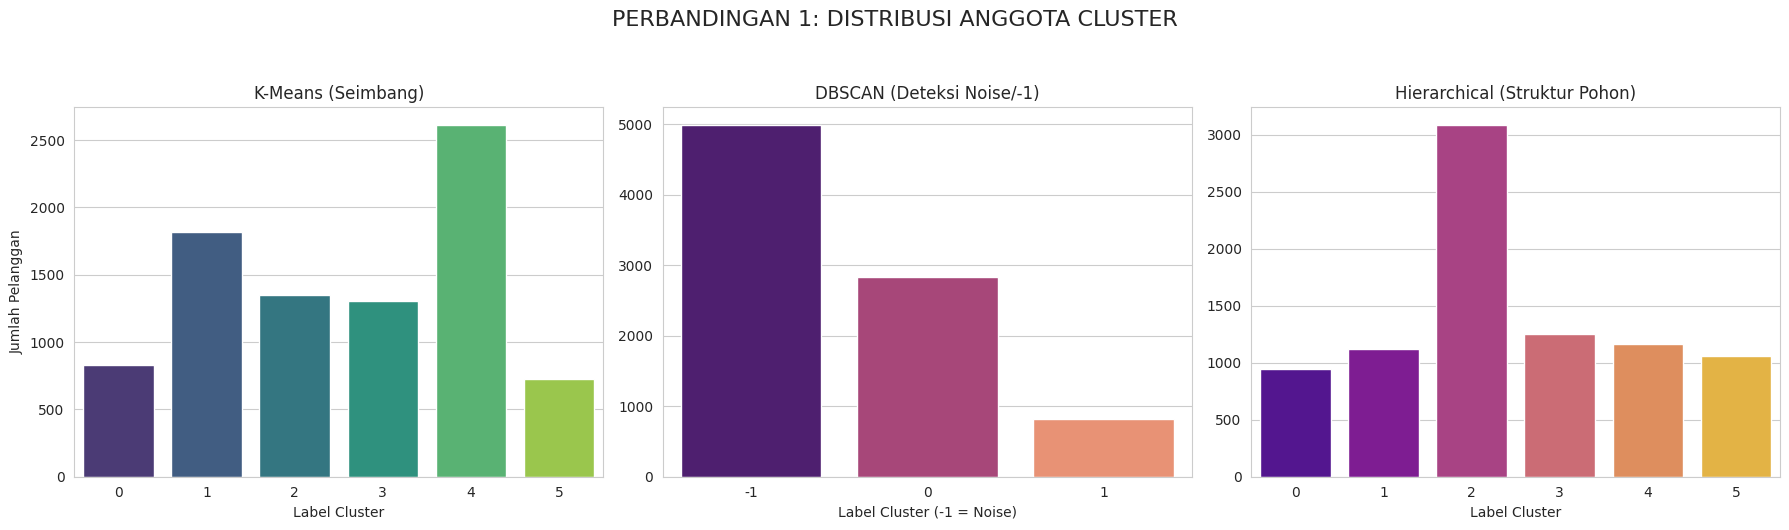

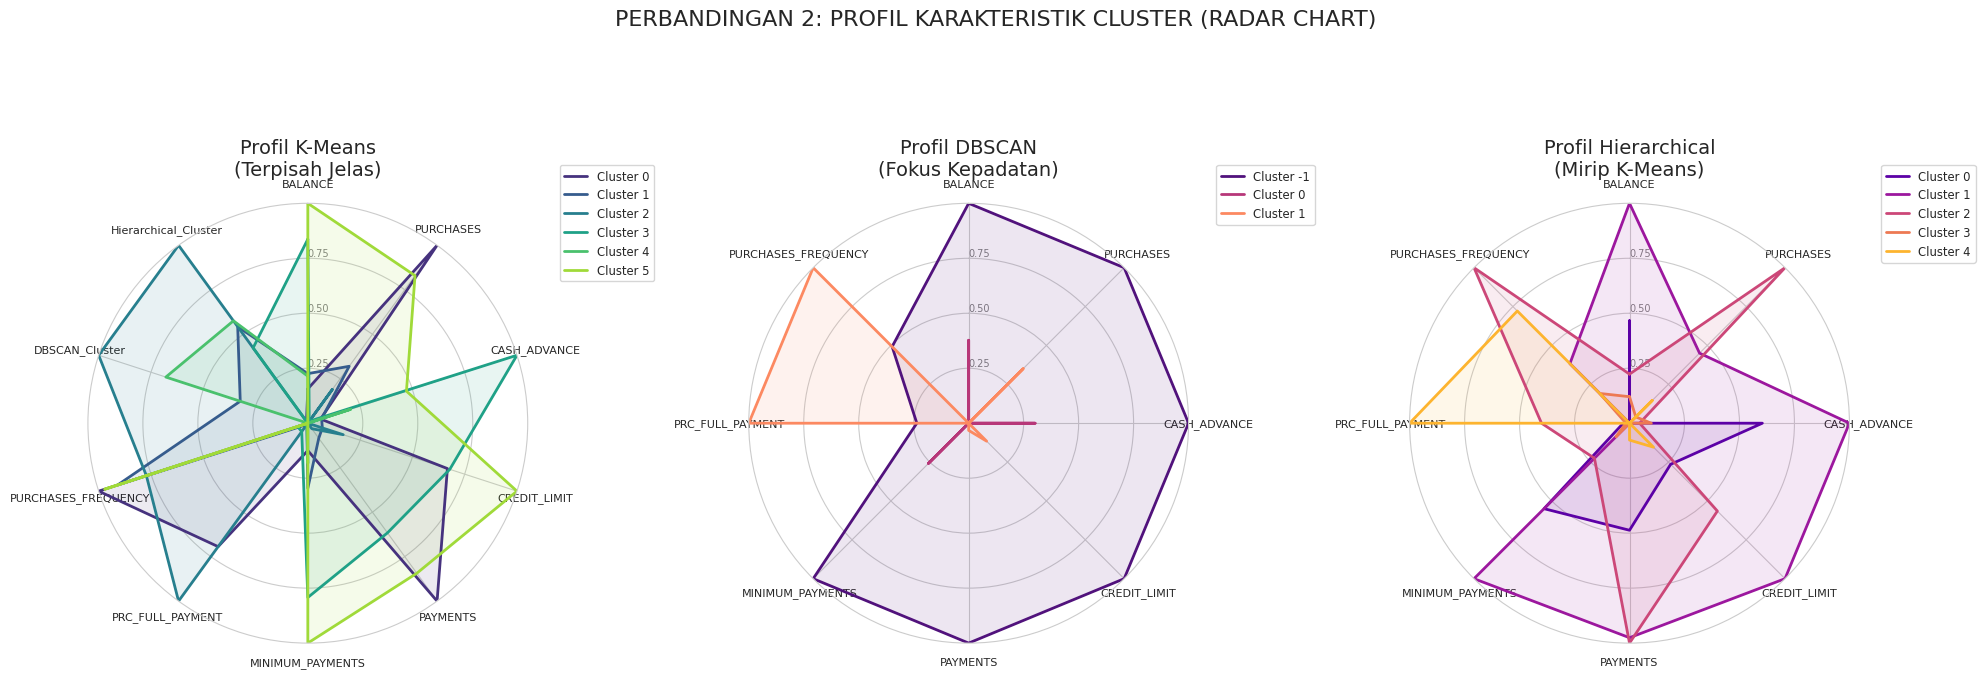

In [61]:
# --- CELL BARU: VISUALISASI KOMPARASI ---
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from math import pi

# ==========================================
# BAGIAN 1: MENAMPILKAN TABEL RANGKUMAN
# ==========================================
print("=== TABEL 1: DISTRIBUSI JUMLAH ANGGOTA CLUSTER ===")
# Mengambil data jumlah cluster yang sudah dihitung sebelumnya
# Asumsi variabel: cluster_counts (KMeans), dbscan_cluster_counts, hierarchical_cluster_counts

# Gabungkan jadi satu dataframe biar rapi
df_dist_compare = pd.DataFrame({
    'Metode': ['K-Means']*len(cluster_counts) + ['DBSCAN']*len(dbscan_cluster_counts) + ['Hierarchical']*len(hierarchical_cluster_counts),
    'Cluster_Label': list(cluster_counts.index) + list(dbscan_cluster_counts.index) + list(hierarchical_cluster_counts.index),
    'Jumlah_Member': list(cluster_counts.values) + list(dbscan_cluster_counts.values) + list(hierarchical_cluster_counts.values)
})
display(df_dist_compare.pivot_table(index='Cluster_Label', columns='Metode', values='Jumlah_Member', aggfunc='sum').fillna(0).astype(int))
print("\n")


# ==========================================
# BAGIAN 2: BAR CHART SIDE-BY-SIDE
# ==========================================
plt.figure(figsize=(18, 5))
plt.suptitle('PERBANDINGAN 1: DISTRIBUSI ANGGOTA CLUSTER', fontsize=16, y=1.05)

# Plot 1: K-Means
plt.subplot(1, 3, 1)
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title('K-Means (Seimbang)', fontsize=12)
plt.xlabel('Label Cluster')
plt.ylabel('Jumlah Pelanggan')

# Plot 2: DBSCAN
plt.subplot(1, 3, 2)
sns.barplot(x=dbscan_cluster_counts.index, y=dbscan_cluster_counts.values, palette='magma')
plt.title('DBSCAN (Deteksi Noise/-1)', fontsize=12)
plt.xlabel('Label Cluster (-1 = Noise)')

# Plot 3: Hierarchical
plt.subplot(1, 3, 3)
sns.barplot(x=hierarchical_cluster_counts.index, y=hierarchical_cluster_counts.values, palette='plasma')
plt.title('Hierarchical (Struktur Pohon)', fontsize=12)
plt.xlabel('Label Cluster')

plt.tight_layout()
plt.show()
print("\n" + "="*80 + "\n")


# ==========================================
# BAGIAN 3: RADAR CHART SIDE-BY-SIDE
# ==========================================
# Fungsi untuk bikin radar chart tunggal di dalam subplot
def create_radar_subplot(ax, df_normalized, title, color_palette):
    # Setup variabel radar
    categories = list(df_normalized.columns)
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Tutup lingkaran

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories, size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.50", "0.75"], color="grey", size=7)
    plt.ylim(0, 1)

    # Plot setiap cluster
    colors = sns.color_palette(color_palette, len(df_normalized))
    for i, (index, row) in enumerate(df_normalized.iterrows()):
        values = row.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Cluster {index}', color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.1)

    ax.set_title(title, size=14, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize='small')

# Setup Canvas Besar
fig = plt.figure(figsize=(20, 7))
plt.suptitle('PERBANDINGAN 2: PROFIL KARAKTERISTIK CLUSTER (RADAR CHART)', fontsize=16, y=1.05)

# Radar 1: K-Means
ax1 = fig.add_subplot(131, polar=True)
create_radar_subplot(ax1, cluster_profiles_normalized, "Profil K-Means\n(Terpisah Jelas)", 'viridis')

# Radar 2: DBSCAN
ax2 = fig.add_subplot(132, polar=True)
# Hapus cluster noise (-1) dari visualisasi biar grafik gak rusak, atau biarkan saja
create_radar_subplot(ax2, cluster_profiles_dbscan_normalized, "Profil DBSCAN\n(Fokus Kepadatan)", 'magma')

# Radar 3: Hierarchical
ax3 = fig.add_subplot(133, polar=True)
create_radar_subplot(ax3, cluster_profiles_hierarchical_normalized, "Profil Hierarchical\n(Mirip K-Means)", 'plasma')

plt.tight_layout()
plt.show()

# **Kesimpulan Akhir & Rekomendasi Strategis**

---

### **Rangkuman Perbandingan Metode**

Berdasarkan komparasi visual (Bar Chart & Radar Chart) di atas:

1.  **K-Means:**
    * *Kelebihan:* Menghasilkan cluster yang paling seimbang (ukuran rata) dan terpisah jelas.
    * *Verdict:* **Paling direkomendasikan** untuk strategi marketing umum karena mudah dikelola.

2.  **DBSCAN:**
    * *Kelebihan:* Sangat jago mendeteksi **Noise (-1)**.
    * *Verdict:* Gunakan khusus untuk **Deteksi Fraud** atau mencari nasabah aneh yang berpotensi macet, bukan untuk segmentasi marketing harian.

3.  **Hierarchical:**
    * *Kelebihan:* Memberikan detail struktur sub-cluster.
    * *Verdict:* Cocok jika kita butuh analisis mendalam (misal: memecah lagi cluster 'Sultan' menjadi 'Sultan Baru' dan 'Sultan Lama').

### **Rekomendasi Bisnis (Action Plan)**

* **Untuk Cluster 'Purchase Tinggi' (Sultan):** Tawarkan program *Loyalty Point*, kenaikan limit otomatis, dan akses lounge bandara. Jangan sampai mereka pindah bank.
* **Untuk Cluster 'Cash Advance Tinggi' (Peminjam):** Edukasi tentang fitur cicilan tetap (fixed installment) untuk menggantikan tarik tunai bunga tinggi. Monitor ketat risiko gagal bayar.
* **Untuk Cluster 'Balance Tinggi tapi Purchase Rendah':** Ini nasabah yang menjadikan kartu kredit sebagai utang jangka panjang. Tawarkan program pelunasan ringan.